In [68]:
import gzip
import pickle
import time
from typing import List

import eli5
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
%load_ext autoreload
%autoreload 2

#### Custom Transformers

In [69]:
class FraudFeatureGenerator(BaseEstimator, TransformerMixin):
    """
    The transformer serves a local
    (the features names are static)
    purpose to generate features.

    Still, it is possible to manually change
    `numeric_features` attribute, but you
    cannot change `amount` feature name
    """
    def __init__(
            self,
            handle_nan: str = "median",
            fill_value: float = 0.0,
            ratio_upper_threshold: float = 100,
            ratio_lower_threshold: float = 0,
            algorithm: str = "linear",
    ):
        self.handle_nan = handle_nan
        self.fill_value = fill_value
        self.ratio_upper_threshold = ratio_upper_threshold
        self.ratio_lower_threshold = ratio_lower_threshold
        self.algorithm = algorithm

        self.epsilon = 1e-4
        self.numeric_features = [
            'amount',
            'oldbalanceOrg',
            'newbalanceOrig',
            'oldbalanceDest',
            'newbalanceDest',
        ]

        self.medians = None
        self.means = None
        self.feature_names_out = None

    def _compute_ratio_(self, X: pd.DataFrame, x_col: str, y_col: str) -> pd.Series:
        ratios = X[x_col] / X[y_col]

        # return pd.Series(np.where(ratios < self.ratio_threshold, self.ratio_threshold, ratios))
        return ratios.apply(lambda x: np.where(x > self.ratio_upper_threshold, self.ratio_upper_threshold, x)).apply(
            lambda x: np.where(x < self.ratio_lower_threshold, self.ratio_lower_threshold, x))

    def fit(self, X, y=None) -> None:
        self.means = {feat: X[feat].mean() for feat in self.numeric_features}
        self.medians = {feat: X[feat].median() for feat in self.numeric_features}

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:

        new_df = pd.DataFrame()

        for feat in self.numeric_features:
            if feat != 'amount':
                new_df[f'{feat}_amount_ratio'] = self._compute_ratio_(X, feat, 'amount')
                if self.handle_nan == 'median':
                    new_df[f'{feat}_amount_ratio'].fillna(new_df[f'{feat}_amount_ratio'].median(), inplace=True)
                elif self.handle_nan == 'median':
                    new_df[f'{feat}_amount_ratio'].fillna(new_df[f'{feat}_amount_ratio'].mean(), inplace=True)
                else:
                    new_df[f'{feat}_amount_ratio'].fillna(self.fill_value, inplace=True)

            if self.algorithm == 'linear':
                new_df[f'{feat}_is_zero'] = (X[feat] > self.epsilon).astype(int)
                new_df[f'{feat}_is_bigger_mean'] = (X[feat] > self.means[feat]).astype(int)
                new_df[f'{feat}_is_bigger_median'] = (X[feat] > self.medians[feat]).astype(int)

        new_df['dest_is_bigger_org'] = (X['oldbalanceDest'] > X['oldbalanceOrg']).astype(int)

        self.feature_names_out = new_df.columns.tolist()

        return new_df

    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out

In [70]:
class LogTransformer(TransformerMixin, BaseEstimator):
    """
    Provides log values of numeric features.
    None (inf) values can be fit with const, median or mean.
    """
    def __init__(self, handle_inf="median", fill_value=0):
        self.handle_inf = handle_inf
        self.fill_value = fill_value
        self.feature_names_out = None

    def fit(self, X, y=None):

        if self.handle_inf == "median":
            logged_X = np.log(X)
            self.fill_value = np.nanmedian(logged_X, axis=0)
        elif self.handle_inf == "mean":
            logged_X = np.log(X)
            self.fill_value = np.nanmean(logged_X, axis=0)
        elif self.handle_inf == "const":
            pass

        self.feature_names_out = [f"{feat}_log" for feat in X.columns]

        return self

    def transform(self, X):
        logged_X = np.log(X)

        return np.where(np.isinf(logged_X), np.expand_dims(self.fill_value, axis=0), logged_X)

    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return input_features

        return self.feature_names_out


In [71]:
class TargetEncoderFixed(TargetEncoder):
    """
    At the moment of development, there was an
    incompatibility problem in `category_encoders` module.

    `get_feature_names_out` method in TargetEncoder took
    only 1 argument (self) while sklearn estimators
    also take 'feature_names_in=None'.

    Simple, lazy and fast solution here :)

    Update: The authors responded to our request and
    promised to fix the issue in the nearset release.
    """
    def get_feature_names_out(self, *arg, **kargs) -> List[str]:
        return self.feature_names_out_

#### Loading data

In [8]:
data = pd.read_csv(r'onlinefraud\onlinefraud.csv')  #nrows=100000

In [9]:
data_sample = data.head(1000)

#### Features

In [10]:
features_to_exclude = [
    'isFlaggedFraud',
    'nameOrig',
    'nameDest',
]

In [11]:
features_to_exclude

['isFlaggedFraud', 'nameOrig', 'nameDest']

In [12]:
target_features = ['isFraud', 'isFlaggedFraud']

target = "isFraud"

In [13]:
features = [col for col in data.columns if col not in target_features + features_to_exclude]

In [14]:
numeric_features = [
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",
]

In [15]:
nominal_features = [
    "type",
]

In [16]:
data[features].head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0


In [17]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### Pipelines

##### linear pipeline

In [20]:
linear_generator = ColumnTransformer(
    transformers=[
        ('ffg', FraudFeatureGenerator(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown="ignore"), nominal_features),
    ],
    remainder='drop'
)

linear_preprocessor = ColumnTransformer(
    transformers=[
        ('log', LogTransformer(handle_inf='const', fill_value=0), numeric_features),
        ('scl', StandardScaler(), numeric_features),
    ],
    remainder='drop'
)

linear_data_pipeline = ColumnTransformer(
    transformers=[
        ('generator', linear_generator, features),
        ('preprocessor', linear_preprocessor, features),
    ],
    remainder='drop'
)

##### tree pipeline

In [21]:
tree_generator = ColumnTransformer(
    transformers=[
        ('ffg', FraudFeatureGenerator(algorithm='tree'), numeric_features),
        ('cat', TargetEncoderFixed(handle_unknown="median"), nominal_features),
    ],
    remainder='drop'
)

tree_preprocessor = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(fill_value=-1), numeric_features),
    ],
    remainder='drop'
)

tree_data_pipeline = ColumnTransformer(
    transformers=[
        ('generator', tree_generator, features),
        ('preprocessor', tree_preprocessor, features),
    ],
    remainder='drop'
)

##### test data pipeline

In [22]:
# Define the pipeline
pipeline = Pipeline([
    ('general_proc', linear_data_pipeline),
    ('regressor', LogisticRegression())
])

In [23]:
data_sample[features].head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0


In [24]:
linear_data_pipeline.fit_transform(data_sample, data_sample['isFraud'])

C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\pandas\core\internals\blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


array([[ 1.        ,  0.        ,  0.        , ..., -0.34075964,
        -0.32324305, -0.35652105],
       [ 1.        ,  0.        ,  0.        , ..., -0.40701718,
        -0.32324305, -0.35652105],
       [ 1.        ,  0.        ,  0.        , ..., -0.41613199,
        -0.32324305, -0.35652105],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.40901883,
        -0.32324305, -0.35652105],
       [ 1.        ,  0.        ,  0.        , ..., -0.3945687 ,
        -0.32324305, -0.35652105],
       [ 1.        ,  0.        ,  0.        , ..., -0.41613199,
        -0.32324305, -0.35652105]])

In [28]:
d_processed = pd.DataFrame(linear_data_pipeline.fit_transform(data_sample, data_sample['isFraud']))
d_processed.columns = linear_data_pipeline.get_feature_names_out()

C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\pandas\core\internals\blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [29]:
d_processed

,generator__ffg__amount_is_zero,generator__ffg__amount_is_bigger_mean,generator__ffg__amount_is_bigger_median,generator__ffg__oldbalanceOrg_amount_ratio,generator__ffg__oldbalanceOrg_is_zero,generator__ffg__oldbalanceOrg_is_bigger_mean,generator__ffg__oldbalanceOrg_is_bigger_median,generator__ffg__newbalanceOrig_amount_ratio,generator__ffg__newbalanceOrig_is_zero,generator__ffg__newbalanceOrig_is_bigger_mean,...,preprocessor__log__amount,preprocessor__log__oldbalanceOrg,preprocessor__log__newbalanceOrig,preprocessor__log__oldbalanceDest,preprocessor__log__newbalanceDest,preprocessor__scl__amount,preprocessor__scl__oldbalanceOrg,preprocessor__scl__newbalanceOrig,preprocessor__scl__oldbalanceDest,preprocessor__scl__newbalanceDest
0,1.0,0.0,0.0,17.290876,1.0,0.0,1.0,16.290876,1.0,0.0,...,9.194174,12.044353,11.984780,0.000000,0.0,-0.436309,-0.334361,-0.340760,-0.323243,-0.356521
1,1.0,0.0,0.0,11.397966,1.0,0.0,1.0,10.397966,1.0,0.0,...,7.530630,9.964065,9.872240,0.000000,0.0,-0.468422,-0.406045,-0.407017,-0.323243,-0.356521
2,1.0,0.0,0.0,1.000000,1.0,0.0,0.0,0.000000,0.0,0.0,...,5.198497,5.198497,0.000000,0.000000,0.0,-0.475200,-0.416188,-0.416132,-0.323243,-0.356521
3,1.0,0.0,0.0,1.000000,1.0,0.0,0.0,0.000000,0.0,0.0,...,5.198497,5.198497,0.000000,9.960907,0.0,-0.475200,-0.416188,-0.416132,-0.312958,-0.356521
4,1.0,0.0,0.0,3.561322,1.0,0.0,1.0,2.561322,1.0,0.0,...,9.364617,10.634749,10.305141,0.000000,0.0,-0.428947,-0.396269,-0.402079,-0.323243,-0.356521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,0.0,6.307042,1.0,0.0,0.0,5.307042,1.0,0.0,...,7.681219,9.522886,9.350254,0.000000,0.0,-0.467202,-0.409694,-0.410724,-0.323243,-0.356521
996,1.0,0.0,0.0,29.751462,1.0,0.0,1.0,28.751462,1.0,0.0,...,9.183889,12.576767,12.542577,0.000000,0.0,-0.436715,-0.276772,-0.284470,-0.323243,-0.356521
997,1.0,0.0,0.0,5.454251,1.0,0.0,1.0,4.454251,1.0,0.0,...,8.130427,9.826822,9.624286,0.000000,0.0,-0.462254,-0.407357,-0.409019,-0.323243,-0.356521
998,1.0,0.0,0.0,7.763119,1.0,0.0,1.0,6.763119,1.0,0.0,...,8.821847,10.871232,10.733332,0.000000,0.0,-0.448626,-0.390931,-0.394569,-0.323243,-0.356521


In [30]:
linear_data_pipeline.get_feature_names_out()

array(['generator__ffg__amount_is_zero',
       'generator__ffg__amount_is_bigger_mean',
       'generator__ffg__amount_is_bigger_median',
       'generator__ffg__oldbalanceOrg_amount_ratio',
       'generator__ffg__oldbalanceOrg_is_zero',
       'generator__ffg__oldbalanceOrg_is_bigger_mean',
       'generator__ffg__oldbalanceOrg_is_bigger_median',
       'generator__ffg__newbalanceOrig_amount_ratio',
       'generator__ffg__newbalanceOrig_is_zero',
       'generator__ffg__newbalanceOrig_is_bigger_mean',
       'generator__ffg__newbalanceOrig_is_bigger_median',
       'generator__ffg__oldbalanceDest_amount_ratio',
       'generator__ffg__oldbalanceDest_is_zero',
       'generator__ffg__oldbalanceDest_is_bigger_mean',
       'generator__ffg__oldbalanceDest_is_bigger_median',
       'generator__ffg__newbalanceDest_amount_ratio',
       'generator__ffg__newbalanceDest_is_zero',
       'generator__ffg__newbalanceDest_is_bigger_mean',
       'generator__ffg__newbalanceDest_is_bigger_median

##### test pipeline with estimator

In [31]:
pipeline.fit(data_sample, data_sample['isFraud'])

C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\pandas\core\internals\blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('general_proc',
                 ColumnTransformer(transformers=[('generator',
                                                  ColumnTransformer(transformers=[('ffg',
                                                                                   FraudFeatureGenerator(),
                                                                                   ['amount',
                                                                                    'oldbalanceOrg',
                                                                                    'newbalanceOrig',
                                                                                    'oldbalanceDest',
                                                                                    'newbalanceDest']),
                                                                                  ('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['type'])]),
                                                  ['step', 'type', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest'...
                                                                                   LogTransformer(handle_inf='const'),
                                                                                   ['amount',
                                                                                    'oldbalanceOrg',
                                                                                    'newbalanceOrig',
                                                                                    'oldbalanceDest',
                                                                                    'newbalanceDest']),
                                                                                  ('scl',
                                                                                   StandardScaler(),
                                                                                   ['amount',
                                                                                    'oldbalanceOrg',
                                                                                    'newbalanceOrig',
                                                                                    'oldbalanceDest',
                                                                                    'newbalanceDest'])]),
                                                  ['step', 'type', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest'])])),
                ('regressor', LogisticRegression())])

In [32]:
eli5.explain_weights_df(pipeline[-1], feature_names=pipeline[:-1].get_feature_names_out())

,target,feature,weight
0,1,<BIAS>,1.311024
1,1,generator__cat__type_CASH_OUT,1.310763
2,1,generator__ffg__oldbalanceOrg_amount_ratio,0.899168
3,1,preprocessor__scl__newbalanceDest,0.808727
4,1,generator__ffg__oldbalanceDest_is_zero,0.679490
5,1,generator__cat__type_TRANSFER,0.644820
6,1,preprocessor__scl__amount,0.475510
7,1,generator__ffg__amount_is_bigger_median,0.417234
8,1,generator__ffg__oldbalanceOrg_is_bigger_mean,0.305304
9,1,generator__ffg__dest_is_bigger_org,0.280502


#### Models

In [33]:
dummy_mf = make_pipeline(
    DummyClassifier(strategy='most_frequent'),
)

dummy_strf = make_pipeline(
    DummyClassifier(strategy='stratified'),
)

In [34]:
lr_par = {
    'C': 100,
    'penalty': 'l2',
    'solver': 'liblinear'
}
lr = Pipeline([
    ('general_proc', linear_data_pipeline),
    ('regressor', LogisticRegression(**lr_par))
])

svm_par = {
    'C': 10,
    'gamma': 'auto',
    'kernel': 'linear'
}
svm = Pipeline([
    ('general_proc', linear_data_pipeline),
    ('regressor', SVC(**svm_par))
])

mlp_par = {
    "activation": "relu",
    "hidden_layer_sizes": (100, 50),
    "learning_rate": "constant",
    "solver": "adam"
}
mlp = Pipeline([
    ('general_proc', linear_data_pipeline),
    ('regressor', MLPClassifier(**mlp_par))
])

In [35]:
ctb_par = {}

ctb = Pipeline([
    ('general_proc', tree_data_pipeline),
    ('regressor', CatBoostClassifier(**ctb_par))
])

xgb_par = {
    "colsample_bytree": 1.0,
    "learning_rate": 0.1,
    "max_depth": 5,
    "n_estimators": 100,
    "subsample": 0.9
}

xgb = Pipeline([
    ('general_proc', tree_data_pipeline),
    ('regressor', XGBClassifier())
])

lgbm_par = {
    "colsample_bytree": 0.9,
    "learning_rate": 0.01,
    "max_depth": 5,
    "min_child_weight": 3,
    "n_estimators": 300,
    "subsample": 0.8
}

lgbm = Pipeline([
    ('general_proc', tree_data_pipeline),
    ('regressor', LGBMClassifier(**lgbm_par))
])

rfc_par = {
    'max_depth': None,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100
}

rfc = Pipeline([
    ('general_proc', tree_data_pipeline),
    ('regressor', RandomForestClassifier(**rfc_par))
])

In [36]:
pipelines = [
    ("Dummy_mf", dummy_mf),
    ("Dummy_strf", dummy_strf),
    ("LogReg", lr),
    ("XGB", xgb),
    ("LGBM", lgbm),
    ("RFC", rfc),
    ("CatBoost", ctb),
    ("MLP", mlp),
    # ("SVM", svm),
]

In [37]:
lr

Pipeline(steps=[('general_proc',
                 ColumnTransformer(transformers=[('generator',
                                                  ColumnTransformer(transformers=[('ffg',
                                                                                   FraudFeatureGenerator(),
                                                                                   ['amount',
                                                                                    'oldbalanceOrg',
                                                                                    'newbalanceOrig',
                                                                                    'oldbalanceDest',
                                                                                    'newbalanceDest']),
                                                                                  ('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['type'])]),
                                                  ['step', 'type', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest'...
                                                                                   LogTransformer(handle_inf='const'),
                                                                                   ['amount',
                                                                                    'oldbalanceOrg',
                                                                                    'newbalanceOrig',
                                                                                    'oldbalanceDest',
                                                                                    'newbalanceDest']),
                                                                                  ('scl',
                                                                                   StandardScaler(),
                                                                                   ['amount',
                                                                                    'oldbalanceOrg',
                                                                                    'newbalanceOrig',
                                                                                    'oldbalanceDest',
                                                                                    'newbalanceDest'])]),
                                                  ['step', 'type', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest'])])),
                ('regressor', LogisticRegression(C=100, solver='liblinear'))])

In [38]:
rfc

Pipeline(steps=[('general_proc',
                 ColumnTransformer(transformers=[('generator',
                                                  ColumnTransformer(transformers=[('ffg',
                                                                                   FraudFeatureGenerator(algorithm='tree'),
                                                                                   ['amount',
                                                                                    'oldbalanceOrg',
                                                                                    'newbalanceOrig',
                                                                                    'oldbalanceDest',
                                                                                    'newbalanceDest']),
                                                                                  ('cat',
                                                                                   TargetEncoderFixed(handle_unknown='median'),
                                                                                   ['type'])]),
                                                  ['step', 'type', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('preprocessor',
                                                  ColumnTransformer(transformers=[('imputer',
                                                                                   SimpleImputer(fill_value=-1),
                                                                                   ['amount',
                                                                                    'oldbalanceOrg',
                                                                                    'newbalanceOrig',
                                                                                    'oldbalanceDest',
                                                                                    'newbalanceDest'])]),
                                                  ['step', 'type', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest'])])),
                ('regressor', RandomForestClassifier())])

#### Load pipelines from files

In [45]:
filenames = [
    "data_mining_CatBoost_Pipeline_2023-05-23.bin.gz",
    "data_mining_Dummy_mf_Pipeline_2023-05-23.bin.gz",
    "data_mining_Dummy_strf_Pipeline_2023-05-23.bin.gz",
    "data_mining_LGBM_Pipeline_2023-05-23.bin.gz",
    "data_mining_LinReg_Pipeline_2023-05-23.bin.gz",
    "data_mining_MLP_Pipeline_2023-05-23.bin.gz",
    "data_mining_RFC_Pipeline_2023-05-23.bin.gz",
    "data_mining_XGB_Pipeline_2023-05-23.bin.gz"
]

In [46]:
def read(file):
    with gzip.open(file, mode="rb") as f:
        return pickle.load(f)

In [ ]:
load_from_file = True

if load_from_file:
    pipelines = [
        (filename.split('data_mining_')[1].split('_Pipeline')[0], read(filename).pipeline
         ) for filename in filenames]

#### Data split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, stratify=data[target])

In [50]:
X_train.shape, X_test.shape

((5090096, 7), (1272524, 7))

In [51]:
y_train.value_counts()

0    5083526
1       6570
Name: isFraud, dtype: int64

In [52]:
y_test.value_counts()

0    1270881
1       1643
Name: isFraud, dtype: int64

#### Train single model

In [55]:
model = rfc

In [56]:
model.fit(X_train, y_train)

Pipeline(steps=[('general_proc',
                 ColumnTransformer(transformers=[('generator',
                                                  ColumnTransformer(transformers=[('ffg',
                                                                                   FraudFeatureGenerator(algorithm='tree'),
                                                                                   ['amount',
                                                                                    'oldbalanceOrg',
                                                                                    'newbalanceOrig',
                                                                                    'oldbalanceDest',
                                                                                    'newbalanceDest']),
                                                                                  ('cat',
                                                                                   TargetEncoderFixed(handle_unknown='median'),
                                                                                   ['type'])]),
                                                  ['step', 'type', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('preprocessor',
                                                  ColumnTransformer(transformers=[('imputer',
                                                                                   SimpleImputer(fill_value=-1),
                                                                                   ['amount',
                                                                                    'oldbalanceOrg',
                                                                                    'newbalanceOrig',
                                                                                    'oldbalanceDest',
                                                                                    'newbalanceDest'])]),
                                                  ['step', 'type', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest'])])),
                ('regressor', RandomForestClassifier())])

In [57]:
y_pred_test = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

print("Confusion matrix:")
print(cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion matrix:
[[1270880       1]
 [      7    1636]]


In [58]:
y_pred_train = model.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)

print(classification_report(y_train, y_pred_train))

print("Confusion matrix:")
print(cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083526
           1       1.00      1.00      1.00      6570

    accuracy                           1.00   5090096
   macro avg       1.00      1.00      1.00   5090096
weighted avg       1.00      1.00      1.00   5090096

Confusion matrix:
[[5083526       0]
 [      0    6570]]


In [59]:
weights = eli5.explain_weights_df(model[-1], feature_names=model[:-1].get_feature_names_out())

In [60]:
weights

,feature,weight,std
0,generator__ffg__oldbalanceOrg_amount_ratio,0.450685,0.286889
1,preprocessor__imputer__newbalanceOrig,0.099617,0.219738
2,generator__ffg__newbalanceOrig_amount_ratio,0.097383,0.229305
3,preprocessor__imputer__newbalanceDest,0.088682,0.133235
4,generator__ffg__newbalanceDest_amount_ratio,0.084570,0.135342
5,preprocessor__imputer__oldbalanceOrg,0.082678,0.098342
6,preprocessor__imputer__amount,0.045902,0.060084
7,generator__cat__type,0.020649,0.031374
8,preprocessor__imputer__oldbalanceDest,0.012296,0.026873
9,generator__ffg__oldbalanceDest_amount_ratio,0.012126,0.021787


#### Advanced training (don't run)

In [54]:
from notebooks.Dzim.data_mining.validation.training import estimate_multiple_models
from notebooks.Dzim.data_mining.validation.training import estimate_model

#### training
model_names, model_pipelines = zip(*pipelines)
metrics, weights = estimate_multiple_models(
    model_pipelines,
    lambda pipeline, _: estimate_model(
        pipeline,
        (X_train, X_test, y_train, y_test),
    ),
    model_names
)

C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\pandas\core\internals\blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\dz

Learning rate set to 0.39419
0:	learn: 0.0296316	total: 817ms	remaining: 13m 36s
1:	learn: 0.0074548	total: 1.38s	remaining: 11m 30s
2:	learn: 0.0039688	total: 1.89s	remaining: 10m 26s
3:	learn: 0.0004088	total: 2.62s	remaining: 10m 53s
4:	learn: 0.0001723	total: 3.21s	remaining: 10m 38s
5:	learn: 0.0001242	total: 3.78s	remaining: 10m 26s
6:	learn: 0.0001007	total: 4.34s	remaining: 10m 15s
7:	learn: 0.0000904	total: 4.88s	remaining: 10m 4s
8:	learn: 0.0000812	total: 5.42s	remaining: 9m 57s
9:	learn: 0.0000770	total: 6.03s	remaining: 9m 56s
10:	learn: 0.0000747	total: 6.52s	remaining: 9m 46s
11:	learn: 0.0000664	total: 7.03s	remaining: 9m 39s
12:	learn: 0.0000628	total: 7.62s	remaining: 9m 38s
13:	learn: 0.0000604	total: 8.14s	remaining: 9m 33s
14:	learn: 0.0000590	total: 8.69s	remaining: 9m 30s
15:	learn: 0.0000580	total: 9.22s	remaining: 9m 27s
16:	learn: 0.0000577	total: 9.73s	remaining: 9m 22s
17:	learn: 0.0000569	total: 10.3s	remaining: 9m 21s
18:	learn: 0.0000565	total: 10.8s	rema

C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\pandas\core\internals\blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\pandas\core\internals\blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\pandas\core\internals\blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [55]:
metrics

set           train                                                    test  \
metric     f1_score cohen_kappa_score precision_score recall_score f1_score   
model                                                                         
Dummy_mf      0.000             0.000           0.000        0.000    0.000   
Dummy_strf    0.001            -0.000           0.001        0.001    0.001   
LinReg        0.851             0.851           0.967        0.759    0.850   
XGB           0.999             0.999           1.000        0.997    0.997   
LGBM          0.868             0.868           0.962        0.791    0.872   
RFC           1.000             1.000           1.000        1.000    0.996   
CatBoost      0.998             0.998           0.999        0.997    0.997   
MLP           0.862             0.862           0.936        0.800    0.862   

set                                                        
metric     cohen_kappa_score precision_score recall_score  
model                                                      
Dummy_mf               0.000           0.000        0.000  
Dummy_strf            -0.001           0.001        0.001  
LinReg                 0.850           0.967        0.758  
XGB                    0.997           1.000        0.995  
LGBM                   0.872           0.963        0.797  
RFC                    0.996           0.998        0.995  
CatBoost               0.997           0.999        0.995  
MLP                    0.862           0.934        0.801

#### Feature importance

In [86]:
for name, pipeline in pipelines:
    try:
        print("#" * 80)
        print(name)
        print(eli5.explain_weights_df(pipeline[-1], feature_names=pipeline[:-1].get_feature_names_out()))
    except Exception:
        print('Not Supported')

################################################################################
CatBoost
                                        feature    weight
0    generator__ffg__oldbalanceOrg_amount_ratio  0.349343
1   generator__ffg__newbalanceOrig_amount_ratio  0.188489
2          preprocessor__imputer__oldbalanceOrg  0.140353
3                 preprocessor__imputer__amount  0.074140
4                          generator__cat__type  0.057856
5         preprocessor__imputer__newbalanceOrig  0.050635
6         preprocessor__imputer__newbalanceDest  0.050307
7   generator__ffg__newbalanceDest_amount_ratio  0.037419
8         preprocessor__imputer__oldbalanceDest  0.031583
9   generator__ffg__oldbalanceDest_amount_ratio  0.017259
10           generator__ffg__dest_is_bigger_org  0.002616
################################################################################
Dummy_mf
None
################################################################################
Dummy_strf
None
######################

#### AUC scores (takes long time to compute)

##### tree

In [47]:
X_train_transformed_tree = pipelines[0][1][:-1].transform(X_train)

In [48]:
X_test_transformed_tree = pipelines[0][1][:-1].transform(X_test)

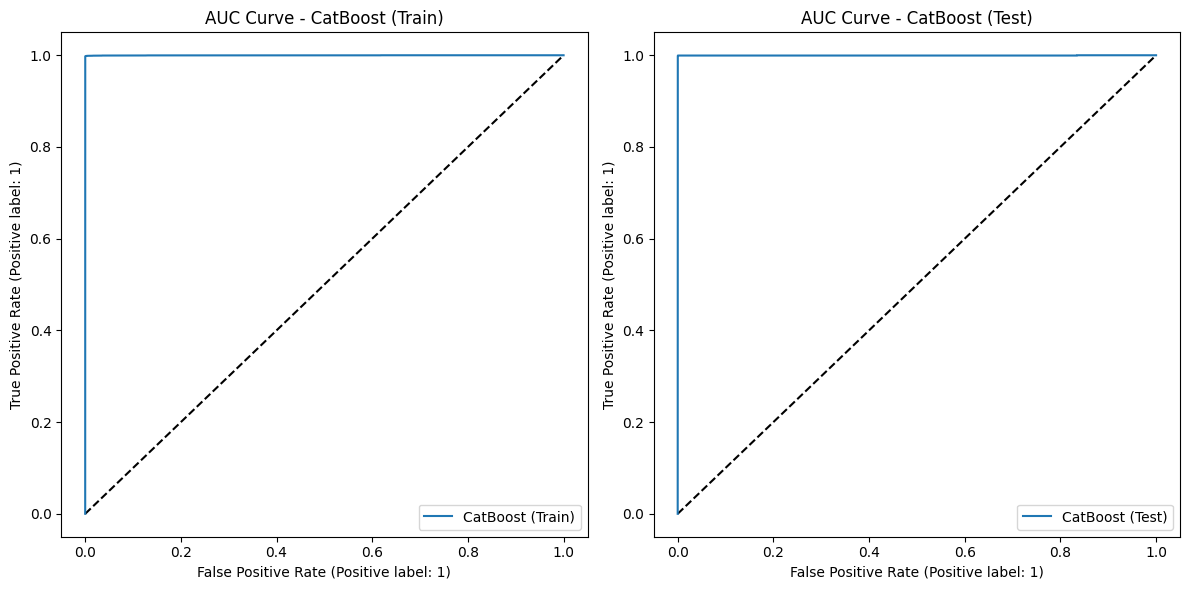

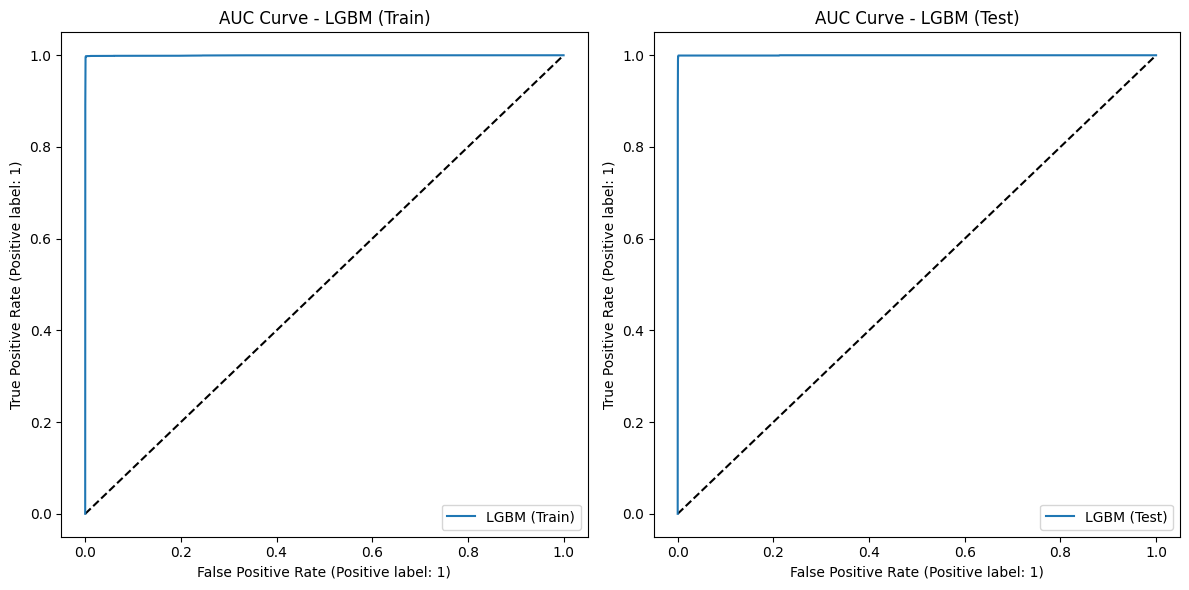

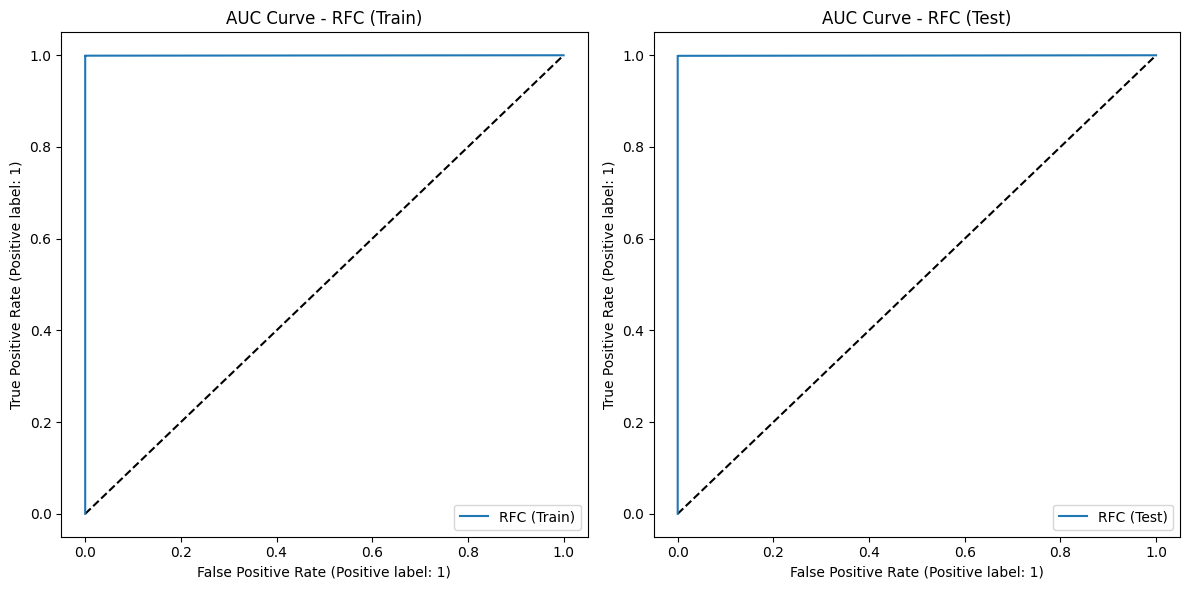

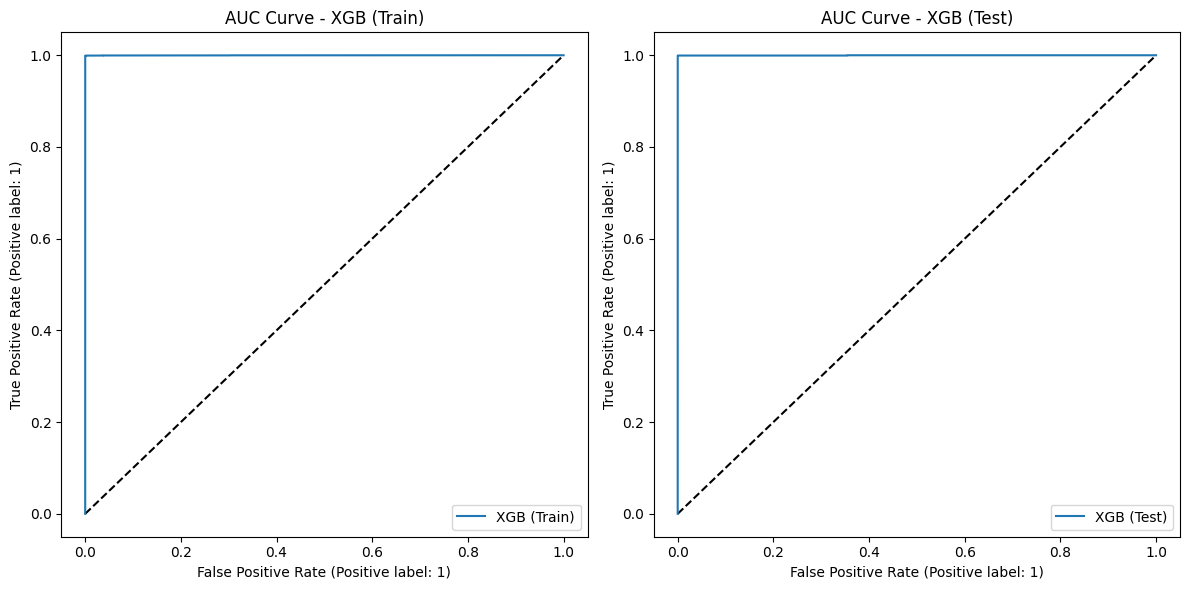

In [52]:
import warnings

results = pd.DataFrame(columns=["auc_train", "auc_test"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for name, pipeline in pipelines:
        if name in ['XGB', 'LGBM', 'CatBoost', 'RFC']:
            # Predict probabilities for training and test data
            y_train_pred_proba = pipeline[-1].predict_proba(X_train_transformed_tree)[:, 1]
            y_test_pred_proba = pipeline[-1].predict_proba(X_test_transformed_tree)[:, 1]

            # Calculate AUC scores
            auc_train = roc_auc_score(y_train, y_train_pred_proba)
            auc_test = roc_auc_score(y_test, y_test_pred_proba)

            # Add the results to the DataFrame
            results.loc[name] = [auc_train, auc_test]

            # Plot AUC curve
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

            # First subplot
            axs[0].plot([0, 1], [0, 1], "k--")  # Diagonal line
            plot_roc_curve(pipeline[-1], X_train_transformed_tree, y_train, ax=axs[0], label=f"{name} (Train)")
            axs[0].set_title(f"AUC Curve - {name} (Train)")
            axs[0].legend()

            # Second subplot
            axs[1].plot([0, 1], [0, 1], "k--")  # Diagonal line
            plot_roc_curve(pipeline[-1], X_test_transformed_tree, y_test, ax=axs[1], label=f"{name} (Test)")
            axs[1].set_title(f"AUC Curve - {name} (Test)")
            axs[1].legend()

            plt.tight_layout()  # Adjust spacing between subplots
            plt.show()


In [53]:
results

,auc_train,auc_test
CatBoost,0.999825,0.999492
LGBM,0.999635,0.999818
RFC,0.999543,0.999391
XGB,0.999831,0.999784


##### linear

In [53]:
# 4 is Logistic Regression pipeline in my case
X_train_transformed_linear = pipelines[4][1][:-1].transform(X_train)


KeyboardInterrupt



In [67]:
X_test_transformed_linear = pipelines[4][1][:-1].transform(X_test)

C:\Users\dzmit\anaconda3\envs\eurostars\lib\site-packages\pandas\core\internals\blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


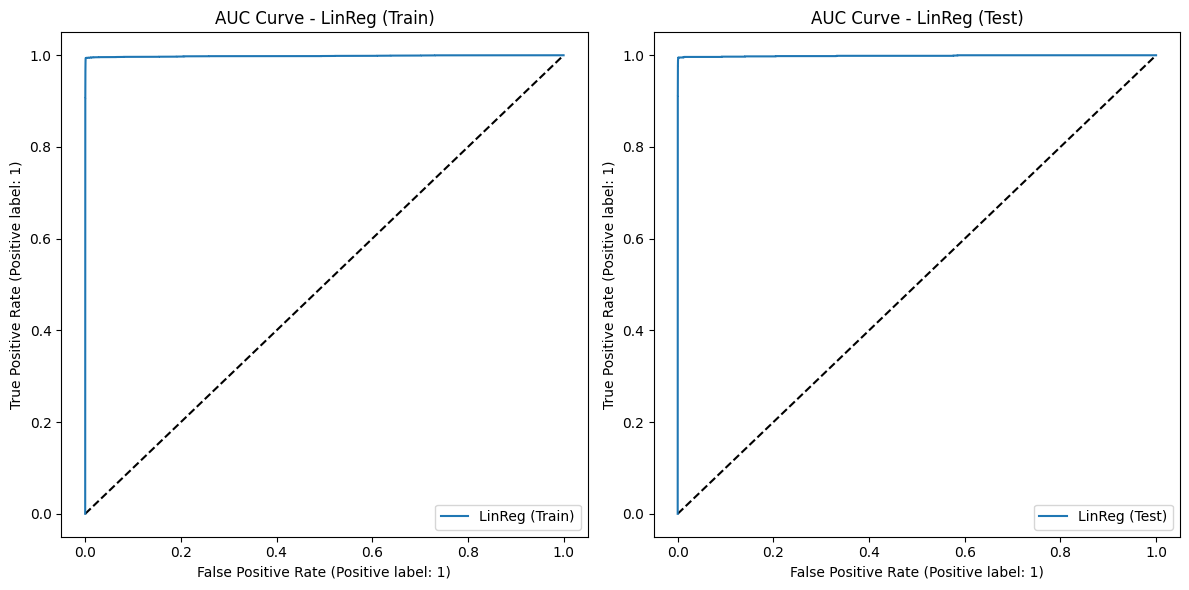

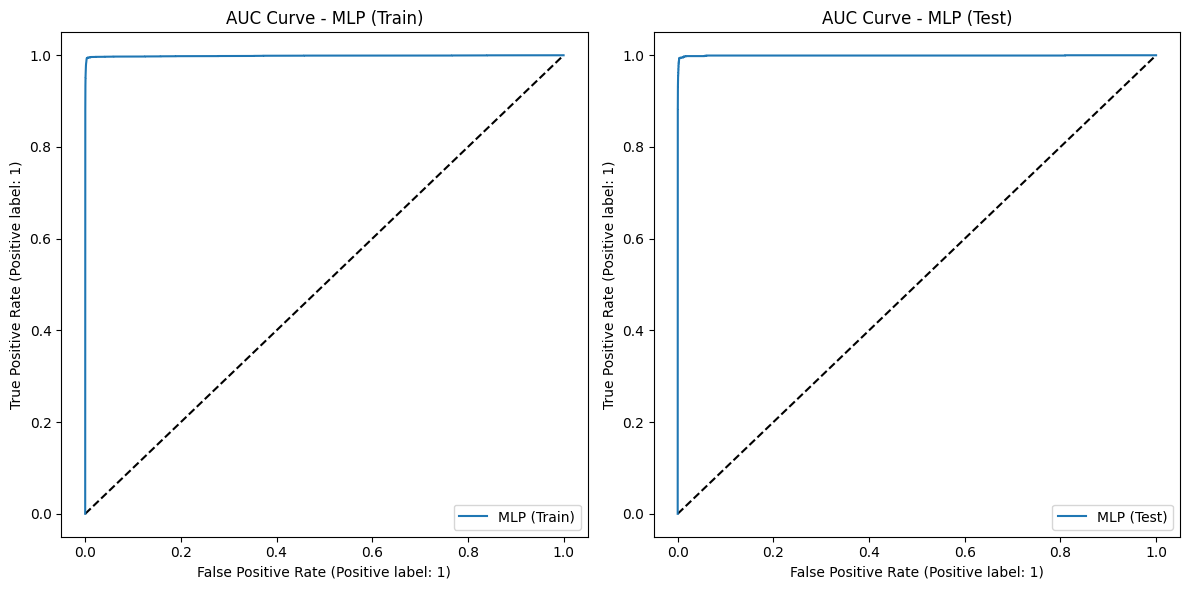

In [70]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for name, pipeline in pipelines:
        if name in ['LinReg', 'MLP']:
            # Predict probabilities for training and test data
            y_train_pred_proba = pipeline[-1].predict_proba(X_train_transformed_linear)[:, 1]
            y_test_pred_proba = pipeline[-1].predict_proba(X_test_transformed_linear)[:, 1]

            # Calculate AUC scores
            auc_train = roc_auc_score(y_train, y_train_pred_proba)
            auc_test = roc_auc_score(y_test, y_test_pred_proba)

            # Add the results to the DataFrame
            results.loc[name] = [auc_train, auc_test]

            # Plot AUC curve
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

            # First subplot
            axs[0].plot([0, 1], [0, 1], "k--")  # Diagonal line
            plot_roc_curve(pipeline[-1], X_train_transformed_linear, y_train, ax=axs[0], label=f"{name} (Train)")
            axs[0].set_title(f"AUC Curve - {name} (Train)")
            axs[0].legend()

            # Second subplot
            axs[1].plot([0, 1], [0, 1], "k--")  # Diagonal line
            plot_roc_curve(pipeline[-1], X_test_transformed_linear, y_test, ax=axs[1], label=f"{name} (Test)")
            axs[1].set_title(f"AUC Curve - {name} (Test)")
            axs[1].legend()

            plt.tight_layout()  # Adjust spacing between subplots
            plt.show()


In [71]:
results

,auc_train,auc_test
CatBoost,0.999825,0.999492
LGBM,0.999635,0.999818
RFC,0.999543,0.999391
XGB,0.999831,0.999784
MLP,0.998684,0.999271
LinReg,0.998363,0.998757


#### Save model

In [65]:
from dataclasses import dataclass


@dataclass(frozen=True)
class ModelContainer:
    pipeline_name: str
    pipeline: Pipeline

    @staticmethod
    def create(
            pipeline_name: str,
            pipeline: Pipeline):
        return ModelContainer(
            pipeline_name=pipeline_name,
            pipeline=pipeline,
        )

In [83]:
def save(filename: str, container: ModelContainer):
    with gzip.open(filename, 'wb') as fp:
        protocol = 3
        pickle.dump(container, fp, protocol=protocol)

In [ ]:
model_to_save = rfc
model_to_save_name = 'RFC_pipeline'

In [ ]:
save(
    filename='some_file',
    container=ModelContainer.create(
        pipeline=model_to_save,
        pipeline_name=model_to_save_name
    )
)

#### Advanced save models (don't run)

In [74]:
from src.common.prediction_model.persistence import FsModelPersistence
from src.common.validation.metrics import aggregate_metrics
from src.common.prediction_model.prediction_model import ModelContainer, ModelMetadata

for name, pipeline in pipelines:
    container = ModelContainer.create(
        pipeline_name=f'data_mining_{name}',
        pipeline=pipeline,
        feature_names=[],
        metadata=ModelMetadata(
            model_name=str(pipeline.__class__.__name__),
            **aggregate_metrics(metrics)['test'].loc[name]
        )
    )
    persistor = FsModelPersistence()
    filename = persistor.save(container)
    print(filename)

data_mining_Dummy_mf_Pipeline_2023-05-23.bin.gz
data_mining_Dummy_strf_Pipeline_2023-05-23.bin.gz
data_mining_LinReg_Pipeline_2023-05-23.bin.gz
data_mining_XGB_Pipeline_2023-05-23.bin.gz
data_mining_LGBM_Pipeline_2023-05-23.bin.gz
data_mining_RFC_Pipeline_2023-05-23.bin.gz
data_mining_CatBoost_Pipeline_2023-05-23.bin.gz
data_mining_MLP_Pipeline_2023-05-23.bin.gz


##### Hyperparameter optimization

In [52]:
# processed_data = tree_data_pipeline.fit_transform(data[features], data[target])
processed_data = linear_data_pipeline.fit_transform(data[features], data[target])

In [114]:
X_train, X_test, y_train, y_test = train_test_split(processed_data, data[target], test_size=0.2, stratify=data[target])

In [98]:
X_train.shape, X_test.shape  # X_cv.shape

((400000, 11), (100000, 11))

In [56]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a RandomForestClassifier object
rfc = RandomForestClassifier()

"""
best_parameters = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
"""

"\nbest_parameters = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}\n"

In [100]:
# Create a GridSearchCV object and fit the data
start = time.time()
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and accuracy score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)
end = time.time()
print(f"Computation tmie: {end - start}")

Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy:  0.9999549999812495
Computation tmie: 1992.9114995002747


In [57]:
# Define the parameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Create a RandomForestClassifier object
lr = LogisticRegression()

"""
{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
"""

"\n{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}\n"

In [117]:
# Create a GridSearchCV object and fit the data
start = time.time()
grid_search = GridSearchCV(lr, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and accuracy scoreB
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)
end = time.time()
print(f"Computation tmie: {end - start}")

Best parameters:  {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy:  0.9998024998624979
Computation tmie: 1396.4422016143799
